In [1]:
"""
Copyright (C) 2022 Dominik Lentrodt

This file is part of pyrot.

pyrot is free software: you can redistribute it and/or modify
it under the terms of the GNU General Public License as published by
the Free Software Foundation, either version 3 of the License, or
(at your option) any later version.

pyrot is distributed in the hope that it will be useful,
but WITHOUT ANY WARRANTY; without even the implied warranty of
MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE.  See the
GNU General Public License for more details.

You should have received a copy of the GNU General Public License
along with pyrot.  If not, see <http://www.gnu.org/licenses/>.
"""

%matplotlib inline

### Import packages

In [2]:
# for calculations
import numpy as np
import scipy as sp
from scipy.signal import argrelextrema

# for plotting
import matplotlib
import matplotlib.pylab as plt

In [3]:
### for development ###
# import os
# import sys
# module_path = os.path.abspath(os.path.join('../src'))
# if module_path not in sys.path:
#     sys.path.append(module_path)

# import pyrot

In [4]:
### if using installed distribution ###
import pyrot

### Example system calculation

Define system

In [5]:
tThin = 0.01 #thin layer
N = [1.0,   4.0, 1.0,   4.0, 1.0] # Refractive index of each layer
T = [ -1, tThin, 1.0, tThin,  -1] # Thicknesses of each layer

omega = np.linspace(0.001, 50., 4000) # incident frequency / wavenumber

z0, z1 = [0.51, 0.71] # positions for Green's function evaluation

In [6]:
cavity = pyrot.Cavity1d(N, T)

Calculate empty cavity scattering

In [7]:
%%time
R_empty = cavity.reflection_intensity(omega)
T_empty = cavity.transmission_intensity(omega)

CPU times: user 4.29 ms, sys: 1.39 ms, total: 5.68 ms
Wall time: 4.86 ms


Calculate reflection minimum

In [8]:
min_inds = argrelextrema(R_empty, np.less)
min_ind = min_inds[0][1]
ref_min = omega[min_ind]+0.000001 # small number to avoid divide by zeroes
print(ref_min)

4.352001750187548


Calculate **Green's function**

In [9]:
%%time
Green_function = cavity.green_function([z0], [z1], omega)[0,0,:]

CPU times: user 3.09 s, sys: 65.9 ms, total: 3.16 s
Wall time: 3.1 s


### Plot

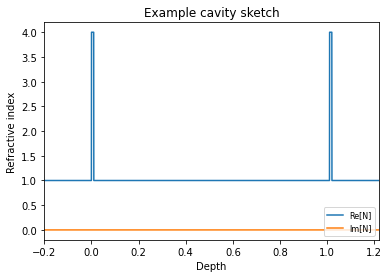

In [10]:
t_tot = np.sum(T[1:-1])
outside_buffer = 0.2
depth = np.linspace(-outside_buffer, t_tot+outside_buffer, 10000)

cavity.draw_cav(depth)

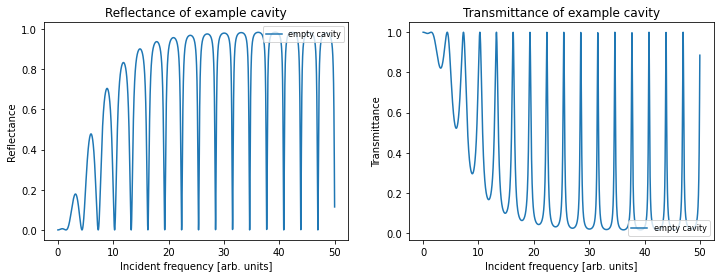

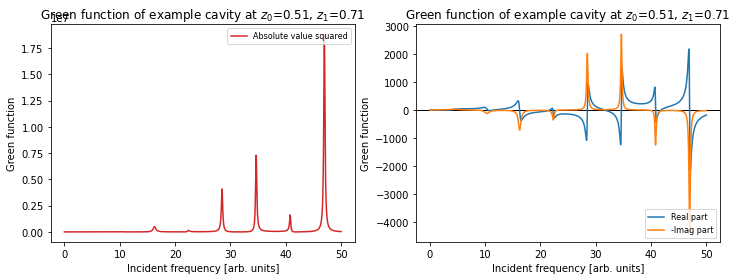

In [11]:
### reflection + Transmission ###
plt.figure(figsize=(6*2,4))

plt.subplot(121, xlabel='Incident frequency [arb. units]', ylabel='Reflectance',
            title='Reflectance of example cavity')
plt.plot(omega, R_empty, '-', label='empty cavity')
plt.legend(loc=1, fontsize=8)

plt.subplot(122, xlabel='Incident frequency [arb. units]', ylabel='Transmittance',
            title='Transmittance of example cavity')
plt.plot(omega, T_empty, '-', label='empty cavity')

plt.legend(loc=4, fontsize=8)

plt.show()

### Green's function ###
plt.figure(figsize=(6*2,4))

plt.subplot(121, xlabel='Incident frequency [arb. units]', ylabel='Green function',
            title='Green function of example cavity at $z_0$={}, $z_1$={}'.format(z0,z1))
plt.plot(omega, np.abs(Green_function*omega**2)**2, 'C3-', label='Absolute value squared')

plt.legend(loc=1, fontsize=8)

sc_f = 1.5
#plt.ylim([0,sc_f*np.abs(Green_function[min_ind])**2])

plt.subplot(122, xlabel='Incident frequency [arb. units]', ylabel='Green function',
            title='Green function of example cavity at $z_0$={}, $z_1$={}'.format(z0,z1))
plt.axhline(0, lw=1, color='k')
plt.plot(omega, np.real(Green_function)*omega**2, '-', label='Real part')
plt.plot(omega, -np.imag(Green_function)*omega**2, '-', label='-Imag part')

plt.legend(loc=4, fontsize=8)
#plt.ylim([np.imag(Green_function[min_ind]), -sc_f*np.imag(Green_function[min_ind])])

plt.show()